# Yelp Review Rating Prediction

## Introduction

In this assignment, we will work on a real world dataset from Yelp. The ultimate goal of your job is to predict the customer rating for businesses like restaurants or bars based on the customer review text.

During this assignment, you will need to build a machine learning pipeline to achive this goal by yourself. But don't worry, this notebook will guide you through those process step by step. To be specific, the tasks in this assignment include:
- Data Pre-processing and Exploratory Data Analysis (EDA)
- Basic Feature Engineering
- Model Design and Implementation
- Model Evaluation

Moreover, at the end of this assignment, we will also let you use the popular machine learning library scikit-learn to build the similar model.

Hopefully, after this assignment you can know the general approach to solve a text related machine learning problem, get a sense on what kind of challenges you may encounter when working on the real world datasets and understand how the machine learning library can boost your work.

## Dataset

Let's first get familiar with the datasets, you should find 6 files:

|Description|Filename|
|---|---|
|Training Set| reviews_train.json  |
|Validation Set   | reviews_dev.json  |
| Test Set  | reviews_test.json  |
|Stopword list file|stopword.list|
|True lables for reviews in validation set|reviews_dev_labels.txt|
|True lables for reviews in test set|reviews_test_labels.txt|

The data in training, validation and test sets are stored in JSON format. Each line of the file is a JSON object. The content of JSON is shown as follows:

```json
{
    'type': 'review',
    'review_id': (encrypted review id),
    'business_id': (encrypted business id),
    'user_id': (encrypted user id),
    'stars': (star rating), # Notice: this field is only available to training set.
    'text': (review text),
    'date': (date, formatted like 'YYYY-MM-DD'),
    'votes': {(vote type): (count)},
}
```

In this assignment, we will focus on using text field (the review content) only to predict the rating stars (the stars field). The review_id field will be used to match the true label in validation and test set.

Note, the true labels for reviews in test set will be released after you finish this assignment, which will be used for final evaluation of the models you built.

#### Now, open the each file and have a look, then move to the next section

In [1]:
# let's first import some useful Python library first
import sys
import re
import json
from collections import defaultdict, Counter
from typing import List, Tuple, Dict
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# let's set the path for each file, they should be placed in the same folder as this notebook
file_stopword = 'stopword.list'

file_train = 'reviews_train.json'

file_dev = 'reviews_dev.json'
file_dev_label = 'reviews_dev_labels.txt'

file_test = 'reviews_test.json'
file_test_label = 'reviews_test_labels.txt'

## Data Pre-processing and Exploratory Data Analysis (EDA)

In this first task, we prepare the training set with the following steps:
- Load the stopwords from file and store them in a set, which will be used to filter out non-useful words
- Extract the useful fields from the training set
- Tokenize the text field and remove the stop words
- Calculate some statistics to verify your implementation.

Here are the requirements for tokenization:
- Turn all the tokens into lower case.
- Remove all the punctuation in the tokens (e.g., “it’s” will become “its”, “?” or “!” will become “”).
- Remove all the tokens that contain numbers.


In [3]:
# We have implemented the stopwords loading for you
def load_stopwords(infile: str) -> set:
    with open(infile) as g:
        stopwords = set(map(lambda x:x.strip(), g.readlines()))
    print(f'{len(stopwords)} stopwords loaded')
    return stopwords

In [4]:
# Now let's load the stopwords as global variables here
stopwords = load_stopwords(file_stopword)

341 stopwords loaded


In [5]:
# TODO: complete the parse_text function, the function takes one comment string
#       and return a list of tokens(words)
def parse_text(text: str) -> List[str]:
    text = re.sub(r'[^a-zA-Z ]', '', text)
    
    # TODO:
    # 1. convert all tokens into lower case
    # 2. remove tokens that in stopwords
    # 3. remvoe empty token like ''
    tokens = [x.strip().lower() for x in text.split(' ') if x and x not in stopwords] # list comprehension 列表推导式
    
    return tokens

In [8]:
# TODO: complete preprocess function to load training/validation/test data from files
#       if label_file is not None, you should read label from the label file, 
#       otherwise, load label from data file, "text" field in each json object. 
def preprocess(data_file: str, label_file: str=None) -> Tuple[List[List[str]], List[int]]:
    review_list, star_list = [], []
    
    reviews = {}
    stars = {}
    with open(data_file, 'r') as f:
        for json_str in f:
            obj = json.loads(json_str)
            # TODO: 
            # 1. load the reivew_id and reivew text from JSON obj, which
            #   is a dictionary after loading to Python
            # 2. using the parse_text function to process the review text
            # 3. save the token list to review map: {review_id => tokens}
            review_id = obj["review_id"]
            review = obj["text"]
            
            tokens = parse_text(review)
            reviews[review_id] = tokens
            
            if label_file is None:
                # TODO:
                # 1. load the label (stars) from JSON obj
                # 2. save tokens and star to output list (i.e., review_list, start_list)
                star = int(obj["stars"])
                review_list.append(tokens)
                star_list.append(star)
    
    if label_file:
        # so we need to manually load stars from file
        # file format: review_id<space>stars
        with open(label_file, 'r') as f:
            lines = f.readlines()
        for line in lines:
            review_id, star = line.strip().split()
            stars[review_id] = int(star)

        for review_id, tokens in reviews.items():
            review_list.append(tokens)
            star_list.append(stars[review_id])
    
    return review_list, star_list

Now let's load the training dataset, you should get 1.25M records

In [9]:
review_list, star_list = preprocess(file_train)

In [10]:
# the length of review_list and star_list should match
assert len(review_list) == len(star_list)

print(f'Number of training samples: {len(review_list)}')

Number of training samples: 1255353


After loading the training dataset, find out top 9 most frequent tokens and corresponding counts in it.

In [15]:
from tqdm import tqdm
# TODO: implement this function to get the top 9 most frequent tokens
def get_top_token_counts(review_list: List[List[str]]) -> List[Tuple[str, int]]:
    
    token_counter = Counter()
    
#     # meet expectation
#     n = 0
#     for tokens in review_list:
#         token_counter.update(tokens)
#         n += 1
#         if n % 100000 == 0:
#             print(n)
    
    # Exceed expectation
    for tokens in tqdm(review_list):
        token_counter.update(tokens)
            
    token_cnt_list = sorted(token_counter.items(), key=lambda x:x[1], reverse=True)
    
    for token, cnt in token_cnt_list[:9]:
        print(f'token={token}\tcount={cnt}')
    
    # We will write the token and its count to a file just
    # in case you need it :)
    with open('token_counts.txt', 'w') as f:
        for token, count in token_cnt_list:
            f.write(f'{token} {count}\n')
    return token_cnt_list

In [16]:
token_cnt_list = get_top_token_counts(review_list)

100%|████████████████████████████████████████████████████████████████████| 1255353/1255353 [00:10<00:00, 125471.39it/s]


token=i	count=3855203
token=the	count=1255431
token=good	count=721552
token=place	count=706729
token=food	count=673892
token=great	count=573051
token=like	count=542963
token=just	count=518714
token=time	count=433290


You should get something like this, it doesn't matter if the numbers are not exactly matched, as long as they are  close:

|Rank |Token|Count|
|---|---|---|
|1|good|721552|
|2|place|706729|
|3 |food|673892|
|4 |great|573051|
|5 |like|542963|
|6 |just|518714|
|7 |time|433290|
|8 |service|411813|
|9 |really|385354|

You should get something like this, it doesn't matter if the numbers are not exactly matched, as long as they are  close:

|Rank |Token|Count|
|---|---|---|
|1|good|721552|
|2|place|706729|
|3 |food|673892|
|4 |great|573051|
|5 |like|542963|
|6 |just|518714|
|7 |time|433290|
|8 |service|411813|
|9 |really|385354|

Next, let's find distribution of user assigned stars, i.e., the number of training instances with 1 star, 2 stars, 3 stars, 4 stars and 5 stars respectively.

In [17]:
# TODO: implement this function to get the star distribution on traning set
def get_label_counts(star_list: List[int]) -> List[int]:
    stars_count = [0] * 5 # 1-5 stars
    for star in star_list:
        stars_count[star-1] += 1

    
    print('star counts:', stars_count)
    print('distribution:', np.array(stars_count, dtype=float) / sum(stars_count))
    return stars_count

In [18]:
stars_count = get_label_counts(star_list)

star counts: [128038, 112547, 178215, 373469, 463084]
distribution: [0.10199362 0.08965367 0.14196405 0.29750118 0.36888748]


In [19]:
def plot_bar_chart(labels, values, title, ylabel):
    fig, ax = plt.subplots()
    ax.bar(labels, values)
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    plt.show()

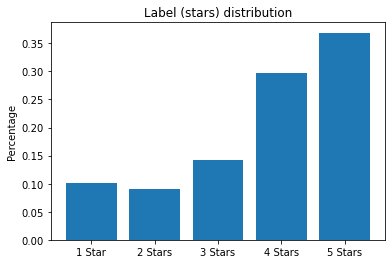

In [20]:
plot_bar_chart(
    labels=['1 Star', '2 Stars', '3 Stars', '4 Stars', '5 Stars'],
    values=np.array(stars_count, dtype=float) / sum(stars_count),
    title='Label (stars) distribution',
    ylabel='Percentage'
)

Do you find something unexpected from the distribution? Will this be problematic in training the model? If so, could you try to find some idea about how to address it and understand why the idea should work?

Wait!! It's not over yet!

Please feel free to try more things to help you understand the datasets, and we encourage you to get familiar with `matplotlib` library, which is very useful in doing visualization in Python. Visualization is a better way to explain what you found in data than words, so you should try to use various types of visualization to present your findings throughout this entire course. To get more visualization ideas, please check out [Matplotlib Gallery](https://matplotlib.org/gallery/index.html), which also includes the source code for implmentation.

## Basic Feature Engineering

In this part, we will design and construct the feature for the machine learning models. Since we are using review text for prediction, the generated text tokens for each training instance will be the source for feature extraction.

### Bag-of-words (BoW) feature

As a baseline approach, let us use a bag-of-words to represent each document, i.e., using a bag of tokens and the corresponding counts in each review, and ignore the order of tokens. For this approach, we need to first define a dictionary. In this baseline model, you can take up to 500 frequent tokens as dictionary and map all the training instances into sparse feature vectors.

So how to encode the feature using dictionary and token count? For example, if your dictionary is [a, b, c, d, e, f, g], and a training instance contains tokens {a:2, b:2, d:1, g:1}, your feature vector will be [2, 2, 0 ,1 ,0, 0, 1].

Note that the sequence of token in dictionary really doesn’t matter, but you should make sure the sequence if the same for all the instances.


In [ ]:
# Let's select top 500 frequent tokens as our dictionary
DICT_SIZE = 500

In [ ]:
# TODO: Create the feature map where each token is mapped to a fixed index between 0-499.
#       Also, make sure the token_cnt_list is sorted when you slice the top DICT_SIZE
def create_feat_map(token_cnt_list: List[Tuple[str, int]], dict_size: int) -> Dict[str, int]:
    feat_map = {}
    

    
    
    return feat_map

In [ ]:
feat_map = create_feat_map(token_cnt_list, DICT_SIZE)

Now, implement the feature extraction function to build feature vector from review tokens

In [ ]:
# TODO: implement the feature exatraction function to construct feature
#       vector for the given review list
def extract_feature(feat_map: Dict[str, int], review_list: List[List[str]]) -> np.ndarray:
    n_sample, n_feat = 
    X = np.zeros((n_sample, n_feat))
    
    
    
    
    return X

In [ ]:
X_train, y_train = extract_feature(feat_map, review_list), star_list

In [ ]:
# You will also need to get the feature for validation set
review_list, star_list = preprocess(file_dev, file_dev_label)
X_val, y_val = extract_feature(feat_map, review_list), star_list

## Model Design and Implementation

Our goal here is to predict the ratings (from 1 star to 5 stars) over items (restaurants, shops, pharmacies, etc.) based on the review text from each user on that item.

We can consider this as a multi-class classification problem where the model takes the feature vector of each review (which we constructed in the previous part) as the input, and predicts the rating (among 1 to 5) as the class label for the item being reviewed.

Specifically, we want you to implement, train and evaluate a regularized multi-class logistic regression (RMLR) method on the training set and validation set we provided, and finally report your results on test set.

### Multi-class Logistic Regression

Let's first recap the Multi-class Logistic Regression.

Similar to binary logistic regression, for the multi-class version of logistic regression we need to 1) formulate the objective function, and 2) derive the update rule for iterative improvement of model parameters (regression coefficients) assuming that we are using gradient ascent (or descent).

Letting $c\in \{1,2,3,...,C\}$ be the class-label indicator, we estimate the probability of the class as:

$$P(y=c|x;W)=\frac{e^{w_c^Tx}}{\sum_{c'=1}^C e^{w_{c'}^Tx}}$$

where 𝒙 is the feature vector of a review, $y\in\{1,2,3,...C\}$ is a class label, and $W$ is the model-parameter matrix whose columns are $w_c$for$c\in \{1,2,3,...,C\}$.

Now, let's implement the function to make prediction based on the parameter $W$.

In [ ]:
# let's first define our model parameter W and initialize it uniformly
W = np.ones((5, DICT_SIZE)) / DICT_SIZE

In [ ]:
# TODO: implement this function to make prediction on one single instance, the output should be
#       the probability of all different class (e.g., [0.1, 0.1, 0.6, 0.15, 0.05])
def predict(W: np.ndarray, x: np.ndarray) -> np.ndarray:
    scores = None
    
    
    

    
    return scores

In [ ]:
# Since each class has the same weight, your function should output 
# equal probability for any sample (e.g., [0.2 0.2 0.2 0.2 0.2])
fake_x = np.zeros(DICT_SIZE)
print(predict(W, fake_x))

Given a training set of labeled pairs $D=\{(x_i, y_i)\}_{i=1}^n$, we optimize the model parameters as:

$$W^* = \arg\max_W \prod_{i=1}^n P(y_i|x_i;W)$$

Notice that we assume all the training data are independent and identically distributed (i.i.d.), so we use a product of the probabilities over individual training pairs.

When we actually implement the algorithm, we often choose to maximize the log of the conditional likelihood (or minimize the negative loglikelihood). This is because computing the product of probabilities in log space will be more stable and the calculations are also easier. Also, we usually add the regularization terms (we use L2 regularization in this assignment) to prevent overfitting. As a result, we can write our regularized loss function as:

$$L(W)=-\frac{1}{n}\sum_{i=1}^n log P(y_i|x_i; W)+\frac{\lambda}{2}\sum_{i=1}^C\|w_i\|^2$$

where λ is a pre-specified parameter that controls the weight of the regularization term.

### Get the gradient of loss function

In order to derive the gradient of our objective function (the regularized
conditional log-likelihood), it is convenient to redefine the output label of i-th input (i.e., $y_i$ ) using a indicator vector $y_i=(y_{i1}, y_{i2},..., y_{iC})^T$, whose elements are defined as

$$y_{ic}=\begin{cases}
1,& \text{if } y_i=c\\
    0,              & \text{otherwise}
\end{cases} $$

In [ ]:
# TODO: implement the function to convert y=5 to indicator vector y_ind=[0,0,0,0,1]
def convert_indicator(y: int) -> np.ndarray:
    y_ind = None
    
    

    
    return y_ind

In [ ]:
print(convert_indicator(5))

Then the conditional probability of $y_i$ given $x_i$ and $W$ can be written as:
$$P(y_i|x_i;W)=\prod_{c=1}^C \bigg(\frac{e^{w_c^Tx_i}}{\sum_{c'=1}^C e^{w_{c'}^Tx_i}} \bigg)^{y_{ic}}
$$

Now we want you to prove that the gradient of $L(W)$ with respect to vector $w_c$ (i.e., $\frac{\partial L(W)}{\partial w_c}$) is equal to:

$$-\frac{1}{n}\sum_{i=1}^n \bigg(y_{ic}-\frac{e^{w_c^Tx_i}}{\sum_{c'=1}^C e^{w_{c'}^Tx_i}} \bigg)x_i + \lambda w_c$$

Notice that the gradient of log-likelihood function with respect to a vector $w_c$ is itself a vector, whose i-th element is defined as $\frac{\partial L(W)}{\partial w_{ci}}$, where $w_{ci}$ is the i-th element of vector $w_c$.

Now, please try to find the gradient from the log-likelihood function, you should derive this step by step on some paper, this process is very necessary, and is asked in many interviews, also the result will be soon used in your own implementation.

In [ ]:
#TODO: implement the function to calculate gradient for W with a single sample
#      so ignore the regularization part (\lambda * w_c) for now
def get_gradient(W: np.ndarray, x: np.ndarray, y: int) -> np.ndarray:
    grad = None
    

    
    
    return grad

### Gradient Descent, Stochastic Gradient Descent and Mini-batch Gradient Descent

A standard approach to the training of logistic regression is to use Gradient Descent (notice that the goal of our problem is to maximize the regularized log-likelihood, so we will actually use gradient ascent instead of gradient descent). Notice that when the training set is very large, it would be computational expensive to compute the gradient on the entire training set for each iteration. A remedy is to use Stochastic Gradient Descent (SGD) instead, which means to update the model parameters using the gradient on only one training instance per iteration.

Generally speaking, the SGD will converge much slower than GD. A midpoint alternative is to use Batched SGD, which means to divide the training set into equally sized subsets (e.g., 100 instances per subset) and to compute the gradient on each subset per iteration. Clearly, there is a trade-off between the number of iterations and the cost of computing the gradient per iteration.

Let the learning rate be $\alpha$, pick the mini-batch GD for your implementation and outline the algorithm. You should specify the update rule for the model parameters ($W$ or $w_c$) in each iteration, how to check the convergence of the solution, the stop criterion and so on.

Now, let's first implement the gradient update function for a single batch of data.

In [ ]:
# TODO: implement this function to perform one iteration of gradient descent
#       on a given batch of data, where lr is the learning rate and regul 
#       is the regularization parameter
def grad_update(W: np.ndarray, X_batch: List[np.ndarray], y_batch: List[int],
                lr: float=0.01, regul:float=0.1) -> np.ndarray:

    # the gradient should have the same shape as W
    batch_grad = np.zeros_like(W)
    
    
    
    

    return W

To help make sure your implementation is correct, we also need to implement the evaluation function to verify the training process is moving towards the direction we want. Now let's implement the function to caculate the log-loss (the direct goal you are optimizing) for the given dataset. 

In [ ]:
# TODO: implement this function to compute accuracy for a given dataset (X, y)
def compute_accuracy(W: np.ndarray, X: np.ndarray, y: List[int]) -> None:
    err = 0
    
    


    print(f'Accuracy is {1.0 - err / len(X)}')

In [ ]:
# TODO: implement this function to compute log-loss for a given dataset (X, y)
def compute_loss(W: np.ndarray, X: np.ndarray, y: List[int], regul: float) -> None:
    loss = 0
    
    

        
    print(f'Loss is {loss}')

Great!! Now let's put everything together and implement the training function for RMLR. During the training process, you will implement the mini-batch gradient descent, use the function you implemented in the previous section to complete the training function.


Some tips here:
- Think about what batch size you could use for the training, and try your ideas. Note that when batch size equals to the number of training data, the mini-batch gradient descent will become the standard gradient descent
- To help make sure the trainig in on the right direction, you should check the value of loss function on training dataset, and the accuracy on validation dataset regularly during the training (e.g., after certain number of batches)
- Think about what stopping criteria you should use for the training
- You may need to shuffle the order of training samples each time you used the entire dataset, this can help make sure the each batch will always be different
- After you figure out the training process, you can tune the learning rate and regularization parameter based on your understanding about how the training works (e.g., if you found your model can get stuck at some point very easily, how about using a dynamic learning rate?)

In [ ]:
# TODO: use the tips above to complete this function for mini-batch GD model trainig
def train_RMLR(X_train: np.ndarray, y_train: List[int], batch_size: int,
               lr: float=0.01, regul:float =0.1) -> np.ndarray:
    print('Start training RMLR...')
    
    # randomly initialize W, you can use np.random.rand
    W = None
    
    print('Initial performance')
    compute_loss(W, X_train, y_train, regul)
    compute_accuracy(W, X_val, y_val)
    
    n_batch = 0
    batch_X = []
    batch_y = []
    
    random_seq = [i for i in range(len(X_train))]
    
    while True: # add your stop criteria here
        for idx in random_seq:
            # construct your mini-batch and start training
            
            
            
            
            
            
            
            
            
            
    print('Training completed successfully!')
    return W

In [ ]:
W = train_RMLR(X_train, y_train, batch_size=100, lr=0.01)

## Model Evaluation

Now you have got the model (i.e., your weight matrix $W$), congratulations! Let's do some evaluation to understand the performance of your model. We will use two metrics (hard one and soft one) to evaluate your rating prediction results.

First, let's make predictions using your model for both training and validation datasets.

In [ ]:
y_pred_train = [predict(W, x).argmax()+1 for x in X_train]
y_pred_val = [predict(W, x).argmax()+1 for x in X_val]

### Hard metrics

The hard metric is the overall Accuracy (under zero/one loss) for your multi-class classifier, which is defined as the number of instances that you correctly predict its star divided by the size of the dataset. In addition, you may also want to compute the per-class accuracy to under stand your model's performance in different classes. 

Let's first implement the per-class accuracy and overall accuracy metrics in the following function.

In [ ]:
# TODO: implement the per-class accuracy and overall accuracy metrics, note
#       here the input is true label list and predicted label list
def multiclass_accuracy_score(y_true: List[int], y_pred: List[int]) -> None:
    count = Counter()
    err = Counter()
    n_count, n_err = 0, 0
    
    
    
    
    

    print(f'Overall accuracy: {1-n_err/n_count}')
    print(f'Per-class accuracy:')
    for star, cnt in sorted(count.items()):
        print(f'Star={star}, accuracy={1-err[star]/cnt}')

Check the accuracy score on both training and validation sets, does the result match your expectation? (<span style="color:red">**You should at least get an overall accuracy score close to 0.5 on validation set**</span>, otherwise please go back and try to improve your model.) What else do you find? Can you think about the potential reason?

In [ ]:
multiclass_accuracy_score(y_train, y_pred_train)
multiclass_accuracy_score(y_val, y_pred_val)

### Soft Metric

The soft metric is the Root Mean Square Error (RMSE) for your prediction results, which is defined as

$$\text{RMSE}=\sqrt{\frac{1}{n}\sum_{i=1}^n(\hat{r}_i-r_i)^2}$$

where $\hat{r}_i$ is your predicted rating for i-th instance, $r_i$ is the corresponding true rating and $n$ is the size of dataset used for testing. The soft metric shows the average difference between your predictions and true ratings.

In [ ]:
# TODO: implement the function to evaluate RMSE, here the input is also
#       two list of labels (true & predicted)
def root_mean_square_err(y_true: List[int], y_pred: List[int]) -> None:
    s = 0.0
    
    
    

    print(f'RMSE={np.sqrt(s / len(y_true))}')

Also check the RMSE on both training and validation sets.

In [ ]:
root_mean_square_err(y_train, y_pred_train)
root_mean_square_err(y_val, y_pred_val)

#### Please note: building a good machine learning model is an iterative process

It's quite normal if you find something wrong during evaluation or if you are not satisfied with your model's result, always feel free to go back check your implementation (if you think there may be a bug), tune the model parameters (e.g., learning rate, batch_size, regularization hyper parameter, etc.) and try again!

## More Ideas for Model Performance Improvement (optional)

If you are lacking ideas of how to further improve your model, you may try following ideas

- Rethink about the feature engineering part, where we took the top 500 frequent tokens. Do all these tokens equally matter, I don't think so. You may want to take a look and think about how to improve the token list, for example, adj, adv, verb may be more important than noun?
- Let's try some advanced optimization approach to replace gradient descent, let's implement the [Adam](https://zhuanlan.zhihu.com/p/32626442) algorithm to our model!!! If you find that's too hard for you, you can pick any one you like other than gradient descent to implement.
- Training samples are biased, let's fix it! You can try to use some sampling techniques to help. If you have no idea, do some research then ;)
- Think the feature engineering again, do all the reviews have the same of tokens? Probably not, how do you address this? Also, we are now simply dropping all the tokens that are not in our pre-selecte list during feature engineering, which apperantly loses some information? Can you help with that?

Once you are good with your own implementation, you can move to the next part!

## Machine Learning toolkit: [scikit-learn (sklearn)](https://scikit-learn.org/stable/index.html)

As a Data Scientist/Analyst, in most of the cases, you don't really need to implement the machine learning algorithm by yourself, there are many very good machine learning libraries in Python that have already implemented most of the standard machine learning models and scikit-learn is one of the most popular ones among them.

However, this doesn't mean implementing a model like what we just did is useless. Implementing a model by yourself is the best way to understand how the model works, and all the experiences you learned will help you use the machine learning library better.

*Before we start, if you are not familiar with scikit-learn at all, please click the link in title and have a tour on its official website. There are some tutorials on their website to help you quickly understand how the library works.*

Now let's use scikit-learn's Logistic Regression library to train the model again.

In [ ]:
from sklearn.linear_model import LogisticRegression

#### Define the model

In [ ]:
# understand the mearning of each parameter
LogisticRegression?
# You can also visit their website to find the explanation of parameters online:
# https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html#sklearn.linear_model.LogisticRegression

In [ ]:
model = LogisticRegression(penalty='l2', tol=0.0001, C=1.0, fit_intercept=True, solver='lbfgs', max_iter=30, 
                           multi_class='auto', verbose=1, n_jobs=6)

After defining the model and its parameter, let's train it using `.fit(...)` function, you will need to pass the trainig data and labels to it.

In [ ]:
model.fit(X_train, y_train)

After the training finishes, you can make prediction using model's `.predict(...)` function, you will also need to pass the test data, which should have exactly the same format as training data

In [ ]:
y_hat_train = model.predict(X_train)
y_hat_val = model.predict(X_val)

Great! Now let's do some evaluation using metrics from scikit-learn's library.

If you are not familiar with these metrics, please go and explore it on scikit-learn's website.

### Evaluate model using sklearn APIs

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import classification_report
from sklearn.metrics import plot_confusion_matrix

#### Accuracy score

In [ ]:
print(f'Trainig accuracy is {accuracy_score(y_train, y_hat_train)}')
print(f'Validation accuracy is {accuracy_score(y_val, y_hat_val)}')

#### MSE & RMSE
Sklean only provides API for MSE, but you can take the square root yourself to get RMSE

In [ ]:
print(f'Trainig RMSE is {np.sqrt(mean_squared_error(y_train, y_hat_train))}')
print(f'Validation RMSE is {np.sqrt(mean_squared_error(y_val, y_hat_val))}')

#### Confusion Matrix

In [ ]:
print('Training set')
disp = plot_confusion_matrix(model, X_train, y_train, cmap=plt.cm.Blues, normalize='true')

In [ ]:
print('Validation set')
disp = plot_confusion_matrix(model, X_val, y_val, cmap=plt.cm.Blues, normalize='true')

#### Classification report

In [ ]:
print('Training set')
print(classification_report(y_train, y_hat_train))

In [ ]:
print('Validation set')
print(classification_report(y_val, y_hat_val))

## Summary

Now you have reached the end of this assignment! Congratulations! In this assignment you have built a machine learning model from scratch for solving a real world problem, and the general approach is aligned with what we have introduced during the class!

You should also have a good sense on how the machine learning library can help boost our modeling work! In most of other assignments, we will primarily use the machine learning library instead of building the wheels ourselves, then the challenge will become how you can use the library well :)

Note: finishing this assignment completely is very crucial as a few other assignments are built on top of the same problem. 

## Additional Work

Let's first define some helper function, to help get you start quickly, we have provided the `token_count_list.txt` which gives the (token, # of appearance) pair from the full training dataset, you can use it to help optimize your features.

You may need to execute the first 6 code blocks in this notebook before starting this section.

In [ ]:
def get_token_count_list():
    token_count_list = []
    with open('token_count_list.txt', 'r') as f:
        for line in f.readlines():
            token, count = line.strip().split()
            token_count_list.append((token, int(count)))
    return token_count_list            

In [ ]:
token_cnt_list = get_token_count_list()

In [ ]:
print(token_cnt_list[:10])

In [ ]:
DICT_SIZE = FEAT_SIZE = 500

In [ ]:
# We provide this function to build feature map and inverse feature map, so
# we can look up index by token and also look up token by index
def create_feat_map(token_cnt_list: List[Tuple[str, int]], dict_size: int) -> Dict[str, int]:
    token_cnt_list.sort(key=lambda x: x[1], reverse=True)
    top_tokens = [x[0] for x in token_cnt_list[:dict_size]]    

    feat_map, inv_feat_map = {}, {}
    for i, token in enumerate(top_tokens):
        feat_map[token] = i
        inv_feat_map[i] = token
    return feat_map, inv_feat_map

In [ ]:
feat_map, inv_feat_map = create_feat_map(token_cnt_list, DICT_SIZE)

Now, we provide the extraction function to build feature vector from review tokens, but note here we made some change:
- normalize the feature vector to account for different review length

In [ ]:
def extract_feature(feat_map: Dict[str, int], review_list: List[List[str]], normalize=True) -> np.ndarray:
    n_sample, n_feat = len(review_list), FEAT_SIZE
    X = np.zeros((n_sample, n_feat))
    for i, tokens in enumerate(review_list):
        feat = X[i]
        for token in tokens:
            if token in feat_map:
                feat[feat_map[token]] += 1
        if normalize and np.sum(X[i]) > 0:
            X[i] /= np.sum(X[i])
    return X

In [ ]:
# Rebuild the training & validation dataset
review_list, star_list = preprocess(file_train)
review_list_val, star_list_val = preprocess(file_dev, file_dev_label)

In [ ]:
# We only need training dataset for feature selection
X_train, y_train = extract_feature(feat_map, review_list), star_list

### Feature Selection using L1 Regularization

Now, we will use the training dataset and L1 regularization to do feature selection. The idea is in linear model, when the input is properly normalized, the absolute value of weights indicates the relative importance of a feature, so

In [ ]:
from sklearn.linear_model import LogisticRegression

In [ ]:
model = LogisticRegression(penalty='l1', tol=0.01, C=1.0, fit_intercept=True, solver='saga', max_iter=10, 
                           multi_class='auto', verbose=1)

In [ ]:
model.fit(X_train, y_train)

In [ ]:
# Preview of the model parameters
model.coef_

In [ ]:
from collections import defaultdict

# Show the model parameters
feat_weights = defaultdict(list)
for star, weights in enumerate(model.coef_):
    for i, w in enumerate(weights):
        token = inv_feat_map[i]
        feat_weights[star].append((token, w))
    feat_weights[star].sort(key=lambda x: abs(x[1]), reverse=True)

In [ ]:
# Top token for each star
for star, values in feat_weights.items():
    print(f'Star={star+1}', 'key tokens:')
    print(values[:20])
    print()

Does the key tokens make sense to you?

Cool! Let's adjust the threshold to select 200 features.

In [ ]:
selected_token = set()
for star, values in feat_weights.items():
    for token, weight in values:
        # TODO: adjust the threshold to select 200 features
        if abs(weight) > ???:
            selected_token.add(token)
        else:
            break
print(f'Number of tokens you selected: {len(selected_token)}')

In [ ]:
print(list(selected_token))

In [ ]:
FEAT_SIZE = len(selected_token)
print(f'Now feature size is {FEAT_SIZE}')

In [ ]:
# Let's rebuild out feature map
new_feat_map = {}
for i, token in enumerate(selected_token):
    new_feat_map[token] = i

Now let's re-extract the features for training and validation dataset

In [ ]:
X_train, y_train = extract_feature(new_feat_map, review_list), star_list

In [ ]:
X_val, y_val = extract_feature(new_feat_map, review_list_val), star_list_val

Great! Now you can re-run the Machine Learning toolkit section to rebuild the model using Scikit-Learn library, please mark down your previous results and compare the results with hashed features. The model evaluation functions is provided for you.

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import classification_report

# Now we put all the evaluation process in a single function 
# Feel free to update and add more
def validate_all(y_train, y_hat_train, y_val, y_hat_val):
    print(f'Trainig accuracy is {accuracy_score(y_train, y_hat_train)}')
    print(f'Validation accuracy is {accuracy_score(y_val, y_hat_val)}')
    print()
    print(f'Trainig RMSE is {np.sqrt(mean_squared_error(y_train, y_hat_train))}')
    print(f'Validation RMSE is {np.sqrt(mean_squared_error(y_val, y_hat_val))}')
    print()
    print('Training set')
    print(classification_report(y_train, y_hat_train))
    print()
    print('Validation set')
    print(classification_report(y_val, y_hat_val))

#### Rerun the model

In [ ]:
model = LogisticRegression(penalty='l2', tol=0.0001, C=1.0, fit_intercept=True, solver='lbfgs', max_iter=30, 
                           multi_class='auto', verbose=1, n_jobs=6)

In [ ]:
model.fit(X_train, y_train)

In [ ]:
y_hat_train = model.predict(X_train)
y_hat_val = model.predict(X_val)

In [ ]:
validate_all(y_train, y_hat_train, y_val, y_hat_val)

We are now using only 40% of the features, but you may find the model performance does not drop a lot. This is the power of feature selection, we kept the most important part for the model and significantly reduced the computation load.

### Random Forest Model

Now let's move on and try the new model we learned this week! The popular tree-based models! First, we need to regenerate the feature vectors withous normalization

In [ ]:
X_train, y_train = extract_feature(new_feat_map, review_list, normalize=True), star_list

In [ ]:
X_val, y_val = extract_feature(new_feat_map, review_list_val, normalize=True), star_list_val

In [ ]:
from sklearn.ensemble import RandomForestClassifier

Read through the scikit-learn API docs and think about what parameters you want to use

In [ ]:
# TODO: add proper parameters for the random forest model
rf_model = RandomForestClassifier(n_estimators=,
                                  criterion=,
                                  max_depth=, 
                                  min_samples_split=,
                                  min_samples_leaf=, 
                                  max_features=, 
                                  n_jobs=, 
                                  verbose=1)

In [ ]:
rf_model.fit(X_train, y_train)

In [ ]:
y_hat_train = rf_model.predict(X_train)
y_hat_val = rf_model.predict(X_val)

In [ ]:
validate_all(y_train, y_hat_train, y_val, y_hat_val)

Does the result match your expectation?

Generaly speacking, Random Forest (RF) is non-linear model, which should have higher complexity than Logistic Regression (LR) - linear model. In other words, the RF should usually peforms better than LR. However, in our rating prediction problem using pure words, linear model is more approperate than tree model, so you please don't struggle if you cannot beat LR model. Instead, you should focus on how can you improve the model by tuning parameters.

If the model performance is not as good as you may expect, think about what you can do to improve the model performance (based on the theory we learned during the video).

You can try to do some experiments with:
- num. of trees (n_estimators)
- max_depth
- max_features

You should also track the training time for each choice of your parameter (see sample code below)

Usually the min_samples_split and min_samples_leaf are also important, but given the volume of our training data, it's hard to pick the correct values, so we will just skip them.

In [ ]:
from time import time

In [ ]:
start_time = time()

# ... your code here

print(f'Time elapsed: {time() - start_time}ms')

### Gradient Boosting Decision Tree (GBDT)

Now it's your time to play with GBDT, select the package you like and start to explore

### More Feature Engineering: Feature Hashing  (Optional for exploration)

The performance of the baseline model is highly dependent on the **size of dictionary** and the **quality** of tokens. If we simply increase the size of dictionary (e.g., extend the size of dictionary from 500 to 5000), then the computational cost will increase and the model will also suffer from severe data sparsity, as the average length of reviews is much shorter than the full size of the dictionary. In order to improve the computational efficiency and utilize the sparsity of the data, we can use feature hashing (a.k.a hashing trick).

Let the size of dictionary be 1000 in this model. Using a hashing function, we can map the 1000 tokens into a vector with a much smaller dimension (i.e., 300 dimensions in your implementation). That is, using a standard hash function we can compute the hash code for each token, and then take its value modulo 300 (e.g., hash(token) % 300). Finally, we take this value as the index for this token in the 300-dimension vector.

It is obvious that there will be collisions in the 300-dimension vector, e.g., some different tokens will have the same index in the 300-dimension vector, meaning some information may be lost in the mapping. However, since our training instances are quite sparse, you will see this may not be a big problem in practice.

Use this part of the code to replace original basic feature engineering code and rerun the model and evaluation.

In [ ]:
FEAT_SIZE = 300

In [ ]:
# Example of hashing
feat_hash = hash('like')
feat_idx = feat_hash % FEAT_SIZE
print(f'feature hash: {feat_hash}, feature index: {feat_idx}')

Now let's use feature hashing trick to re-do the feature engineering

In [ ]:
# TODO: implement the new feature exatraction function using feature hashing
#       to construct feature vector for the given review list
# Use this function to replace:
# def extract_feature(feat_map: Dict[str, int], review_list: List[List[str]]) -> np.ndarray: ...
def extract_feature_feat_hashing(review_list: List[List[str]]) -> np.ndarray:
    n_sample, n_feat = len(review_list), FEAT_SIZE
    X = np.zeros((n_sample, n_feat+1))
    for i, tokens in enumerate(review_list):
        feat = X[i]
        for token in tokens:
            if token in selected_token:
                feat[hash(token) % FEAT_SIZE] += 1
            else:
                feat[n_feat] += 1
        if np.sum(X[i]) > 0:
            X[i] /= np.sum(X[i])
    return X

In [ ]:
X_train, y_train = extract_feature_feat_hashing(review_list), star_list

In [ ]:
X_val, y_val = extract_feature_feat_hashing(review_list_val), star_list_val